# Feed Forward Neural Network

In [5]:
import numpy as np

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop, Adam

import edward as ed
from edward.models import Categorical, Normal, Beta, PointMass
from edward.models import Mixture, Categorical, Normal
from keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import History
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

## Generate data

In [146]:
n_data = 2000
n_periods = 3
a = -0.5; b = 0.5
x_data = np.linspace(a, b, n_data)
x_data = np.reshape(x_data, (n_data, 1))
y_data_00 = np.sin(2*np.pi*n_periods*x_data/(b-a))
y_data_01 = y_data_00+np.random.normal(loc=0, scale=0.1, size=(n_data,1))
y_data_02 = y_data_00+np.random.normal(loc=0, scale=0.2, size=(n_data,1))
y_data_03 = y_data_00+np.random.normal(loc=0, scale=0.3, size=(n_data,1))

n_pred = 2000
X_pred = np.reshape(np.linspace(1.25*a, 1.25*b, n_pred), (n_pred, 1))
y_pred = np.sin(2*np.pi*n_periods*X_pred/(b-a))
print('One period is {0} data points.'.format(n_data/n_periods))

One period is 666.6666666666666 data points.


### No noise

No handles with labels found to put in legend.


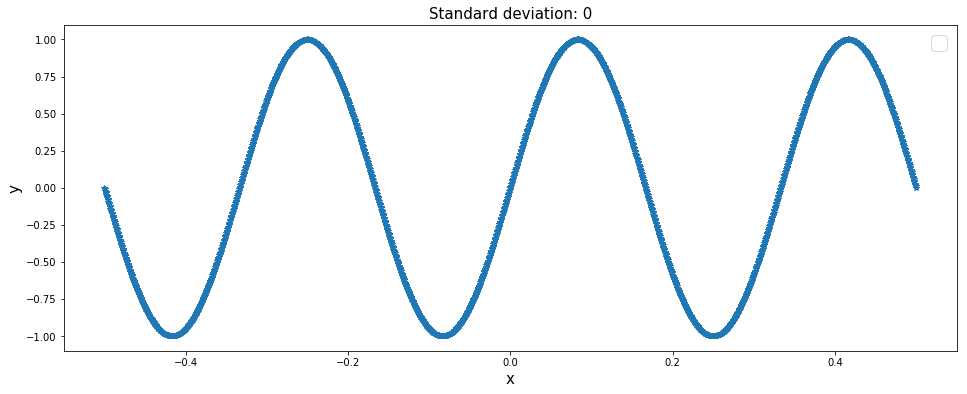

In [298]:
plt.figure(figsize=(16,6))
plt.plot(x_data, y_data_00, '*')
plt.title('Standard deviation: 0', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


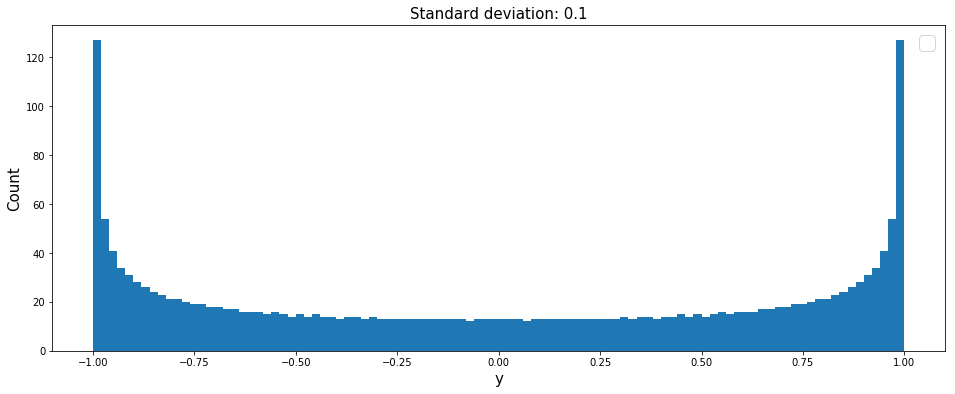

In [148]:
plt.figure(figsize=(16,6))
plt.hist(y_data_00, bins=100)
plt.title('Standard deviation: 0.1', fontsize=15)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Standard deviation: 0.1

No handles with labels found to put in legend.


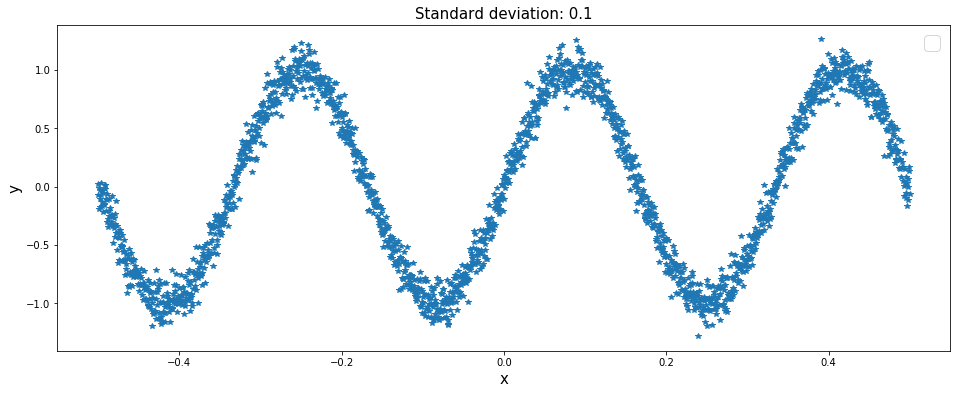

In [149]:
plt.figure(figsize=(16,6))
plt.plot(x_data, y_data_01, '*')
plt.title('Standard deviation: 0.1', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


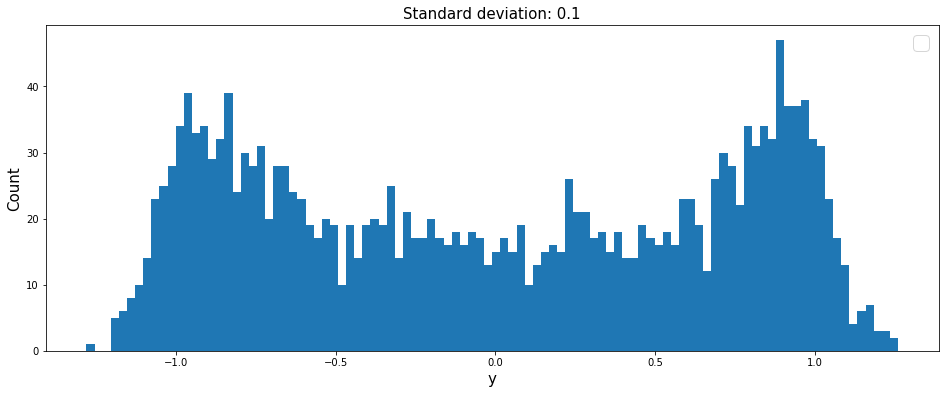

In [150]:
plt.figure(figsize=(16,6))
plt.hist(y_data_01, bins=100)
plt.title('Standard deviation: 0.1', fontsize=15)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Standard deviation: 0.2

No handles with labels found to put in legend.


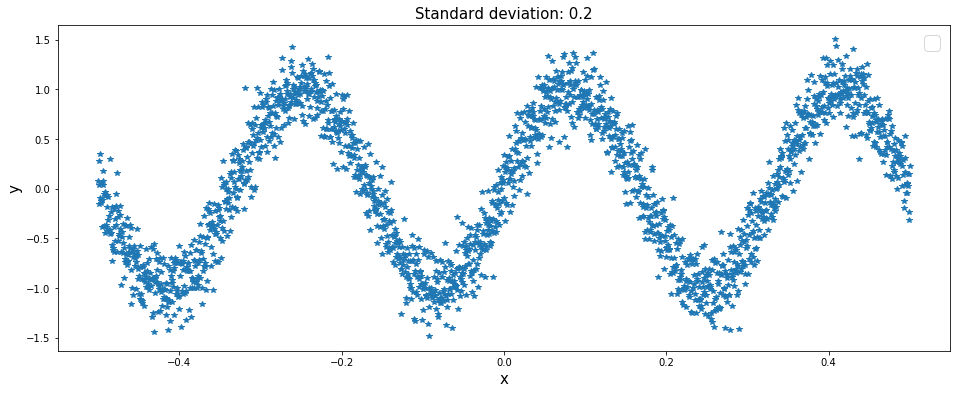

In [151]:
plt.figure(figsize=(16,6))
plt.plot(x_data, y_data_02, '*')
plt.title('Standard deviation: 0.2', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


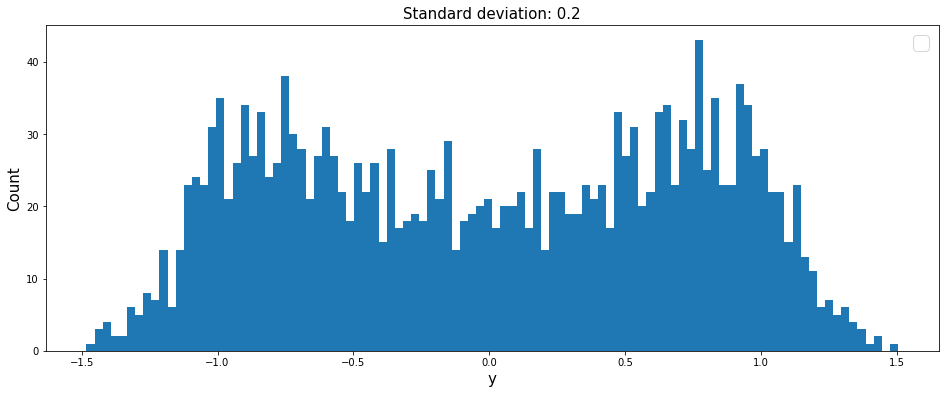

In [152]:
plt.figure(figsize=(16,6))
plt.hist(y_data_02, bins=100)
plt.title('Standard deviation: 0.2', fontsize=15)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Standard deviation: 0.2

No handles with labels found to put in legend.


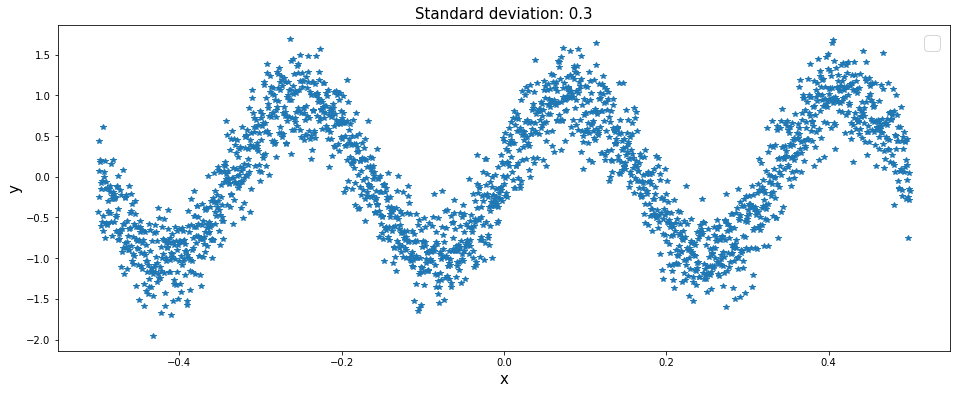

In [299]:
plt.figure(figsize=(16,6))
plt.plot(x_data, y_data_03, '*')
plt.title('Standard deviation: 0.3', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


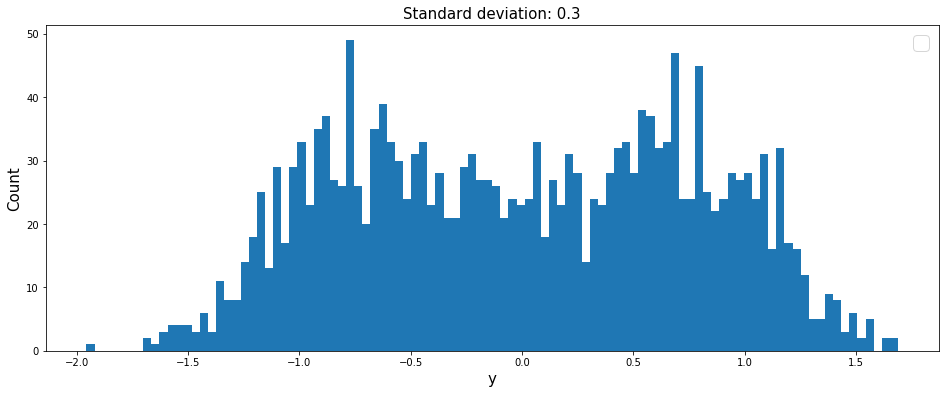

In [300]:
plt.figure(figsize=(16,6))
plt.hist(y_data_03, bins=100)
plt.title('Standard deviation: 0.3', fontsize=15)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Hyperparameters

In [155]:
test_size = 0.25
batch_size = 64 
epochs = 20
D = 1     # Number of features
K = 1    # Number of mixture components

## Create supervised problem

In [156]:
X_train_00, X_test_00, y_train_00, y_test_00 = train_test_split(x_data, y_data_00, test_size=test_size, shuffle=True)
X_train_01, X_test_01, y_train_01, y_test_01 = train_test_split(x_data, y_data_01, test_size=test_size, shuffle=True)
X_train_02, X_test_02, y_train_02, y_test_02 = train_test_split(x_data, y_data_02, test_size=test_size, shuffle=True)
X_train_03, X_test_03, y_train_03, y_test_03 = train_test_split(x_data, y_data_03, test_size=test_size, shuffle=True)

In [157]:
print('Data points in train set: {0}.'.format(len(X_train_00)))
print('Data points in test set: {0}.'.format(len(X_test_00)))
print("Shape of features in training data: {}".format(X_train_00.shape))
print("Shape of output in training data: {}".format(y_train_00.shape))
print("Shape of features in test data: {}".format(X_test_00.shape))
print("Shape of output in test data: {}".format(y_test_00.shape))

Data points in train set: 1500.
Data points in test set: 500.
Shape of features in training data: (1500, 1)
Shape of output in training data: (1500, 1)
Shape of features in test data: (500, 1)
Shape of output in test data: (500, 1)


### Standard deviation: 0

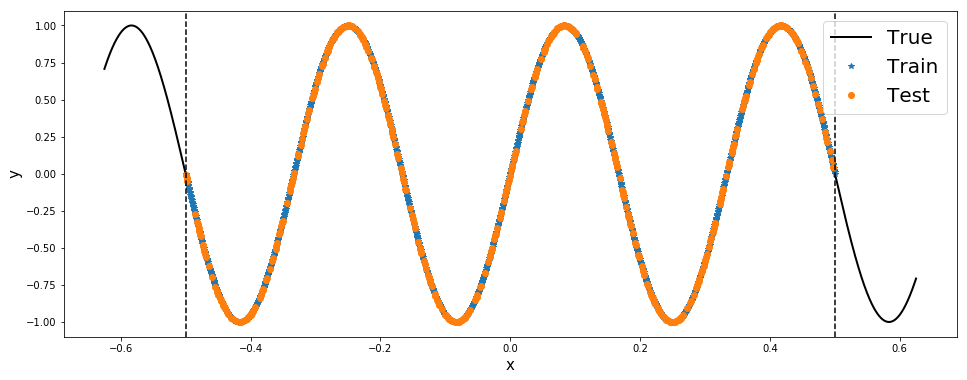

In [158]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train_00, y_train_00, '*', label='Train')
plt.plot(X_test_00, y_test_00, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Standard deviation: 0.1

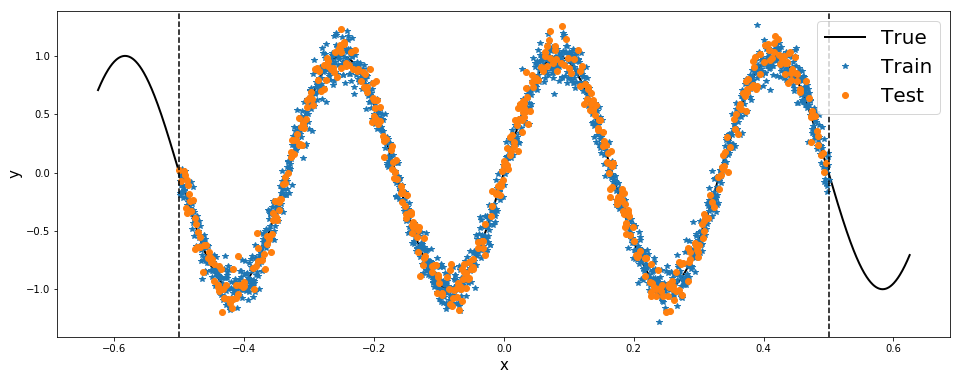

In [159]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train_01, y_train_01, '*', label='Train')
plt.plot(X_test_01, y_test_01, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Standard deviation: 0.2

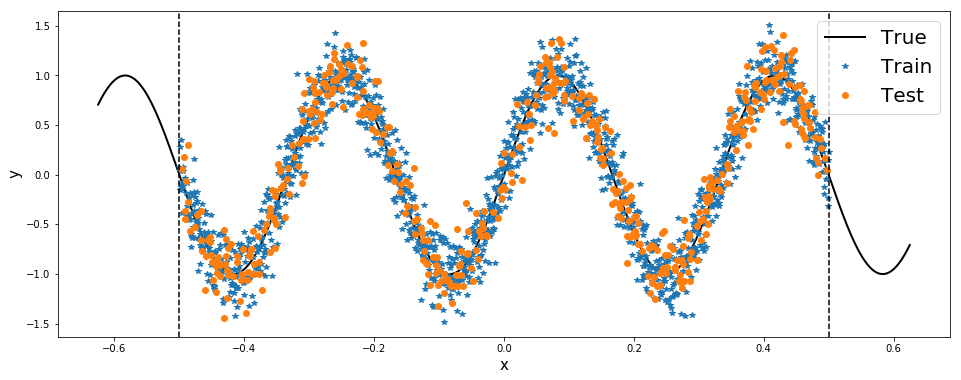

In [160]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train_02, y_train_02, '*', label='Train')
plt.plot(X_test_02, y_test_02, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Standard deviation: 0.3

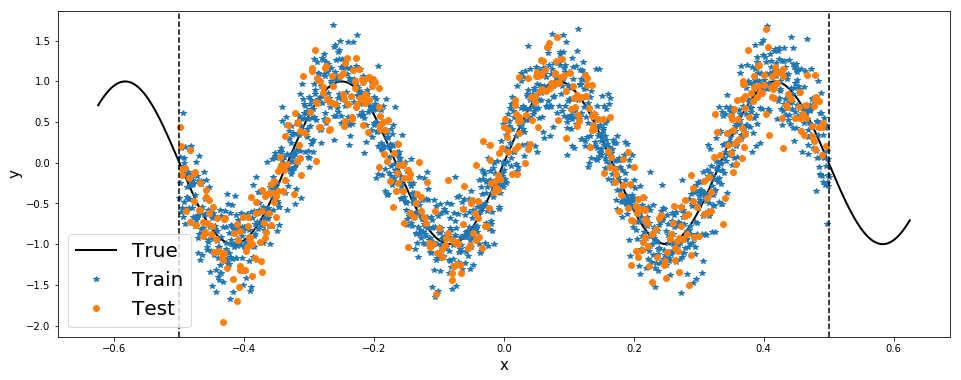

In [161]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train_03, y_train_03, '*', label='Train')
plt.plot(X_test_03, y_test_03, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Feed forward neural network

### Build network

In [215]:
def build_ffnn():
    X = Input(shape=(1,))
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(X)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    y = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform')(h)
    model = Model(inputs=X, outputs=y)
    
    return model

### Optimizer

In [216]:
def compile_ffnn(model, lr):
    adam = Adam(lr=lr, 
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=None, 
                decay=0.0, 
                amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

## Train model

### Standard deviation: 0

In [301]:
model_00 = build_ffnn()

In [302]:
n_epoch = 0
train_loss_00 = np.array([])
test_loss_00 = np.array([])

In [303]:
lr = 1e-3
model_00 = compile_ffnn(model_00, lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model_00.fit(x=X_train_00, y=y_train_00, validation_data=(X_test_00, y_test_00), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=64, verbose=2)
train_loss_00 = np.append(train_loss_00, history.history['loss'])
test_loss_00 = np.append(test_loss_00, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 1/200
 - 19s - loss: 0.4909 - val_loss: 0.5008
Epoch 2/200
 - 0s - loss: 0.4746 - val_loss: 0.4883
Epoch 3/200
 - 0s - loss: 0.4605 - val_loss: 0.4796
Epoch 4/200
 - 0s - loss: 0.4506 - val_loss: 0.4773
Epoch 5/200
 - 0s - loss: 0.4457 - val_loss: 0.4750
Epoch 6/200
 - 0s - loss: 0.4416 - val_loss: 0.4708
Epoch 7/200
 - 0s - loss: 0.4358 - val_loss: 0.4630
Epoch 8/200
 - 0s - loss: 0.4262 - val_loss: 0.4514
Epoch 9/200
 - 0s - loss: 0.4134 - val_loss: 0.4374
Epoch 10/200
 - 0s - loss: 0.3989 - val_loss: 0.4225
Epoch 11/200
 - 0s - loss: 0.3823 - val_loss: 0.4026
Epoch 12/200
 - 0s - loss: 0.3625 - val_loss: 0.3812
Epoch 13/200
 - 0s - loss: 0.3419 - val_loss: 0.3608
Epoch 14/200
 - 0s - loss: 0.3193 - val_loss: 0.3310
Epoch 15/200
 - 0s - loss: 0.2883 - val_loss: 0.2925
Epoch 16/200
 - 0s - loss: 0.2533 - val_loss: 0.2524
Epoch 17/200
 - 0s - loss: 0.2192 - val_loss: 0.2241
Epoch 18/200
 - 0s - loss: 0.1883 - val_loss: 0.1910
Epoch 1

 - 0s - loss: 8.9409e-04 - val_loss: 0.0011
Epoch 153/200
 - 0s - loss: 0.0011 - val_loss: 6.7764e-04
Epoch 154/200
 - 0s - loss: 8.1659e-04 - val_loss: 0.0012
Epoch 155/200
 - 0s - loss: 9.2911e-04 - val_loss: 7.7806e-04
Epoch 156/200
 - 0s - loss: 7.6215e-04 - val_loss: 6.0102e-04
Epoch 157/200
 - 0s - loss: 7.6202e-04 - val_loss: 6.3116e-04
Epoch 158/200
 - 0s - loss: 6.4430e-04 - val_loss: 6.5085e-04
Epoch 159/200
 - 0s - loss: 7.3176e-04 - val_loss: 7.9625e-04
Epoch 160/200
 - 0s - loss: 7.1362e-04 - val_loss: 6.8667e-04
Epoch 161/200
 - 0s - loss: 6.8820e-04 - val_loss: 4.9528e-04
Epoch 162/200
 - 0s - loss: 6.5942e-04 - val_loss: 5.2601e-04
Epoch 163/200
 - 0s - loss: 8.1283e-04 - val_loss: 9.3598e-04
Epoch 164/200
 - 0s - loss: 7.6560e-04 - val_loss: 5.3409e-04
Epoch 165/200
 - 0s - loss: 7.4047e-04 - val_loss: 6.3852e-04
Epoch 166/200
 - 0s - loss: 6.6931e-04 - val_loss: 5.6720e-04
Epoch 167/200
 - 0s - loss: 6.0220e-04 - val_loss: 6.0361e-04
Epoch 168/200
 - 0s - loss: 6.4328

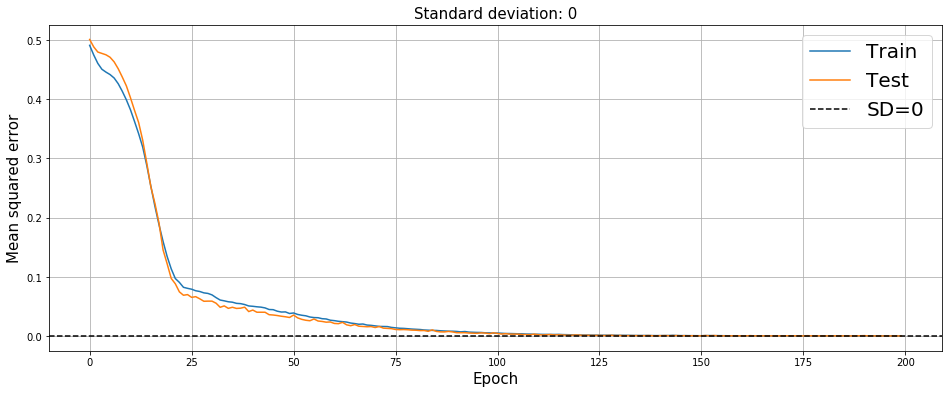

In [305]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_00)), train_loss_00, label='Train')
plt.plot(range(len(test_loss_00)), test_loss_00, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.title('Standard deviation: 0', fontsize=15)
plt.axhline(0, linestyle='--', color='k', label='SD=0')
plt.legend(fontsize=20)
plt.grid()
plt.show()

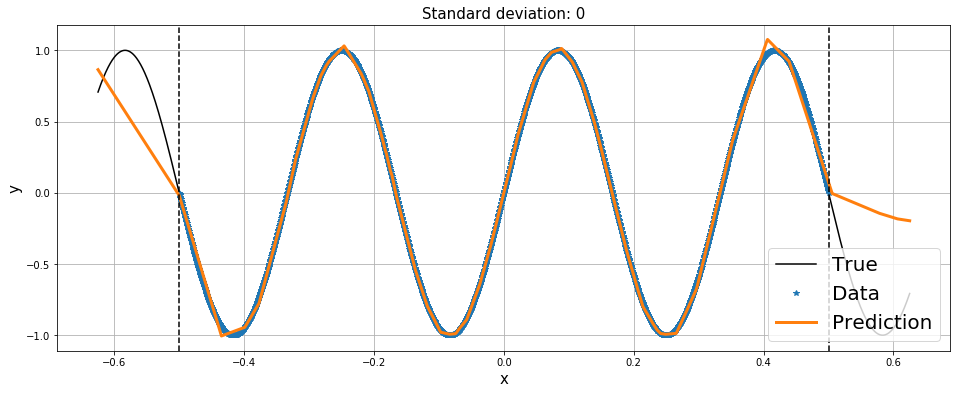

In [306]:
y_pred_model = model_00.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data_00, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Standard deviation: 0', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Standard deviation: 0.1

In [250]:
model_01 = build_ffnn()

In [251]:
n_epoch = 0
train_loss_01 = np.array([])
test_loss_01 = np.array([])

In [252]:
lr = 1e-3
model_01 = compile_ffnn(model_01, lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model_01.fit(x=X_train_01, y=y_train_01, validation_data=(X_test_01, y_test_01), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=64, verbose=2)
train_loss_01 = np.append(train_loss_01, history.history['loss'])
test_loss_01 = np.append(test_loss_01, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 1/200
 - 1s - loss: 0.5009 - val_loss: 0.4822
Epoch 2/200
 - 0s - loss: 0.4826 - val_loss: 0.4731
Epoch 3/200
 - 0s - loss: 0.4740 - val_loss: 0.4671
Epoch 4/200
 - 0s - loss: 0.4692 - val_loss: 0.4633
Epoch 5/200
 - 0s - loss: 0.4654 - val_loss: 0.4598
Epoch 6/200
 - 0s - loss: 0.4618 - val_loss: 0.4570
Epoch 7/200
 - 0s - loss: 0.4582 - val_loss: 0.4526
Epoch 8/200
 - 0s - loss: 0.4533 - val_loss: 0.4479
Epoch 9/200
 - 0s - loss: 0.4470 - val_loss: 0.4416
Epoch 10/200
 - 0s - loss: 0.4390 - val_loss: 0.4314
Epoch 11/200
 - 0s - loss: 0.4278 - val_loss: 0.4194
Epoch 12/200
 - 0s - loss: 0.4128 - val_loss: 0.4001
Epoch 13/200
 - 0s - loss: 0.3914 - val_loss: 0.3760
Epoch 14/200
 - 0s - loss: 0.3674 - val_loss: 0.3513
Epoch 15/200
 - 0s - loss: 0.3366 - val_loss: 0.3134
Epoch 16/200
 - 0s - loss: 0.2968 - val_loss: 0.2749
Epoch 17/200
 - 0s - loss: 0.2568 - val_loss: 0.2364
Epoch 18/200
 - 0s - loss: 0.2138 - val_loss: 0.1884
Epoch 19

Epoch 154/200
 - 0s - loss: 0.0113 - val_loss: 0.0137
Epoch 155/200
 - 0s - loss: 0.0122 - val_loss: 0.0113
Epoch 156/200
 - 0s - loss: 0.0114 - val_loss: 0.0113
Epoch 157/200
 - 0s - loss: 0.0115 - val_loss: 0.0111
Epoch 158/200
 - 0s - loss: 0.0117 - val_loss: 0.0104
Epoch 159/200
 - 0s - loss: 0.0112 - val_loss: 0.0113
Epoch 160/200
 - 0s - loss: 0.0119 - val_loss: 0.0120
Epoch 161/200
 - 0s - loss: 0.0124 - val_loss: 0.0123
Epoch 162/200
 - 0s - loss: 0.0119 - val_loss: 0.0108
Epoch 163/200
 - 0s - loss: 0.0115 - val_loss: 0.0111
Epoch 164/200
 - 0s - loss: 0.0121 - val_loss: 0.0127
Epoch 165/200
 - 0s - loss: 0.0124 - val_loss: 0.0125
Epoch 166/200
 - 0s - loss: 0.0113 - val_loss: 0.0105
Epoch 167/200
 - 0s - loss: 0.0117 - val_loss: 0.0107
Epoch 168/200
 - 0s - loss: 0.0111 - val_loss: 0.0118
Epoch 169/200
 - 0s - loss: 0.0116 - val_loss: 0.0115
Epoch 170/200
 - 0s - loss: 0.0118 - val_loss: 0.0103
Epoch 171/200
 - 0s - loss: 0.0122 - val_loss: 0.0118
Epoch 172/200
 - 0s - loss: 

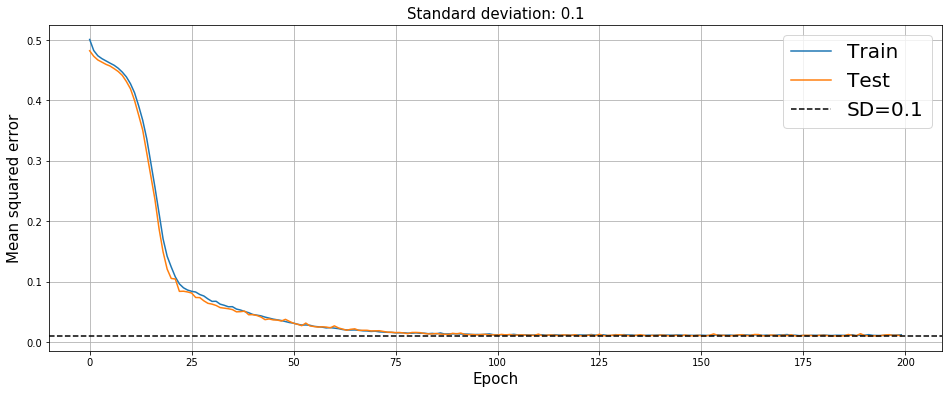

In [253]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_01)), train_loss_01, label='Train')
plt.plot(range(len(test_loss_01)), test_loss_01, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.title('Standard deviation: 0.1', fontsize=15)
plt.axhline(0.1**2, linestyle='--', color='k', label='SD=0.1')
plt.legend(fontsize=20)
plt.grid()
plt.show()

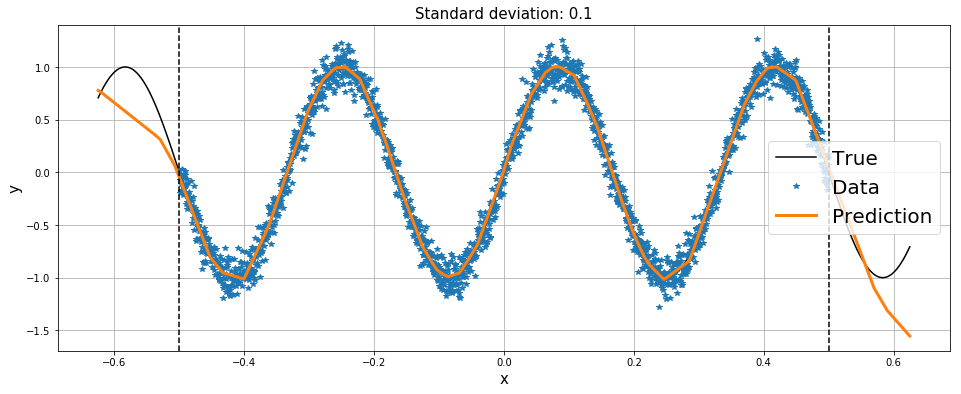

In [255]:
y_pred_model = model_01.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data_01, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Standard deviation: 0.1', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Standard deviation: 0.2

In [256]:
model_02 = build_ffnn()

In [257]:
n_epoch = 0
train_loss_02 = np.array([])
test_loss_02 = np.array([])

In [258]:
lr = 1e-3
model_02 = compile_ffnn(model_02, lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model_02.fit(x=X_train_02, y=y_train_02, validation_data=(X_test_02, y_test_02), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=64, verbose=2)
train_loss_02 = np.append(train_loss_02, history.history['loss'])
test_loss_02 = np.append(test_loss_02, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 1/200
 - 1s - loss: 0.5150 - val_loss: 0.5298
Epoch 2/200
 - 0s - loss: 0.4968 - val_loss: 0.5187
Epoch 3/200
 - 0s - loss: 0.4894 - val_loss: 0.5145
Epoch 4/200
 - 0s - loss: 0.4871 - val_loss: 0.5131
Epoch 5/200
 - 0s - loss: 0.4850 - val_loss: 0.5110
Epoch 6/200
 - 0s - loss: 0.4824 - val_loss: 0.5088
Epoch 7/200
 - 0s - loss: 0.4803 - val_loss: 0.5065
Epoch 8/200
 - 0s - loss: 0.4766 - val_loss: 0.5032
Epoch 9/200
 - 0s - loss: 0.4732 - val_loss: 0.4988
Epoch 10/200
 - 0s - loss: 0.4664 - val_loss: 0.4933
Epoch 11/200
 - 0s - loss: 0.4584 - val_loss: 0.4824
Epoch 12/200
 - 0s - loss: 0.4470 - val_loss: 0.4736
Epoch 13/200
 - 0s - loss: 0.4356 - val_loss: 0.4613
Epoch 14/200
 - 0s - loss: 0.4189 - val_loss: 0.4355
Epoch 15/200
 - 0s - loss: 0.3960 - val_loss: 0.4126
Epoch 16/200
 - 0s - loss: 0.3697 - val_loss: 0.3830
Epoch 17/200
 - 0s - loss: 0.3395 - val_loss: 0.3512
Epoch 18/200
 - 0s - loss: 0.3043 - val_loss: 0.3015
Epoch 19

Epoch 154/200
 - 0s - loss: 0.0443 - val_loss: 0.0445
Epoch 155/200
 - 0s - loss: 0.0444 - val_loss: 0.0491
Epoch 156/200
 - 0s - loss: 0.0457 - val_loss: 0.0443
Epoch 157/200
 - 0s - loss: 0.0439 - val_loss: 0.0449
Epoch 158/200
 - 0s - loss: 0.0448 - val_loss: 0.0448
Epoch 159/200
 - 0s - loss: 0.0444 - val_loss: 0.0451
Epoch 160/200
 - 0s - loss: 0.0450 - val_loss: 0.0461
Epoch 161/200
 - 0s - loss: 0.0450 - val_loss: 0.0449
Epoch 162/200
 - 0s - loss: 0.0438 - val_loss: 0.0462
Epoch 163/200
 - 0s - loss: 0.0449 - val_loss: 0.0440
Epoch 164/200
 - 0s - loss: 0.0442 - val_loss: 0.0436
Epoch 165/200
 - 0s - loss: 0.0439 - val_loss: 0.0451
Epoch 166/200
 - 0s - loss: 0.0437 - val_loss: 0.0455
Epoch 167/200
 - 0s - loss: 0.0443 - val_loss: 0.0474
Epoch 168/200
 - 0s - loss: 0.0453 - val_loss: 0.0430
Epoch 169/200
 - 0s - loss: 0.0430 - val_loss: 0.0443
Epoch 170/200
 - 0s - loss: 0.0436 - val_loss: 0.0456
Epoch 171/200
 - 0s - loss: 0.0439 - val_loss: 0.0430
Epoch 172/200
 - 0s - loss: 

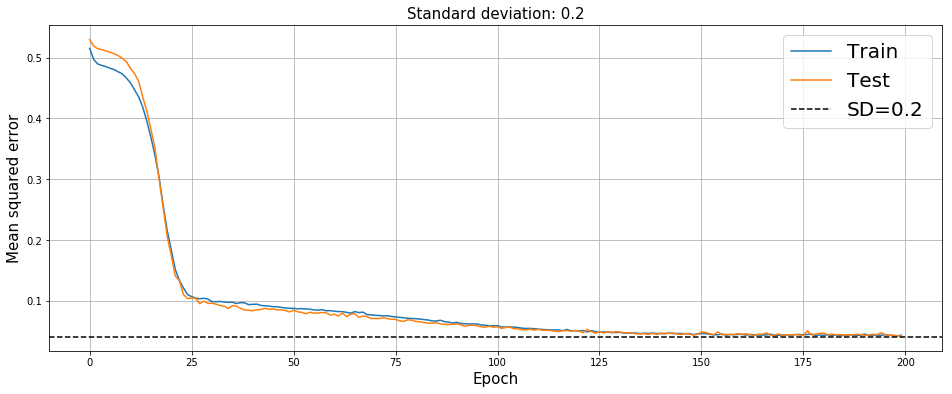

In [259]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_02)), train_loss_02, label='Train')
plt.plot(range(len(test_loss_02)), test_loss_02, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.title('Standard deviation: 0.2', fontsize=15)
plt.axhline(0.2**2, linestyle='--', color='k', label='SD=0.2')
plt.legend(fontsize=20)
plt.grid()
plt.show()

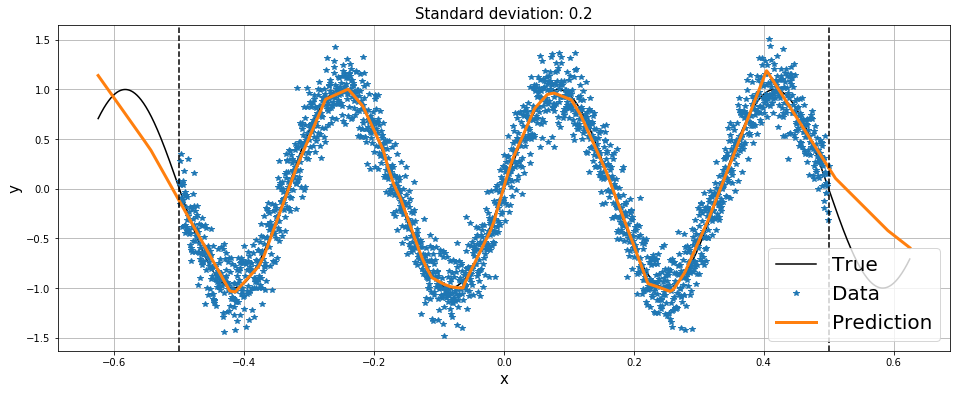

In [260]:
y_pred_model = model_02.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data_02, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Standard deviation: 0.2', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Standard deviation: 0.3

In [261]:
model_03 = build_ffnn()

In [262]:
n_epoch = 0
train_loss_03 = np.array([])
test_loss_03 = np.array([])

In [265]:
lr = 1e-3
model_03 = compile_ffnn(model_03, lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model_03.fit(x=X_train_03, y=y_train_03, validation_data=(X_test_03, y_test_03), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=64, verbose=2)
train_loss_03 = np.append(train_loss_03, history.history['loss'])
test_loss_03 = np.append(test_loss_03, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 201/400
 - 1s - loss: 0.0992 - val_loss: 0.1001
Epoch 202/400
 - 0s - loss: 0.0991 - val_loss: 0.1035
Epoch 203/400
 - 0s - loss: 0.0984 - val_loss: 0.1015
Epoch 204/400
 - 0s - loss: 0.0980 - val_loss: 0.1022
Epoch 205/400
 - 0s - loss: 0.0981 - val_loss: 0.0995
Epoch 206/400
 - 0s - loss: 0.0967 - val_loss: 0.1012
Epoch 207/400
 - 0s - loss: 0.0948 - val_loss: 0.1009
Epoch 208/400
 - 0s - loss: 0.0947 - val_loss: 0.1012
Epoch 209/400
 - 0s - loss: 0.0958 - val_loss: 0.1011
Epoch 210/400
 - 0s - loss: 0.0956 - val_loss: 0.0994
Epoch 211/400
 - 0s - loss: 0.0967 - val_loss: 0.1040
Epoch 212/400
 - 0s - loss: 0.0962 - val_loss: 0.0996
Epoch 213/400
 - 0s - loss: 0.0946 - val_loss: 0.0998
Epoch 214/400
 - 0s - loss: 0.0959 - val_loss: 0.1006
Epoch 215/400
 - 0s - loss: 0.0962 - val_loss: 0.0996
Epoch 216/400
 - 0s - loss: 0.0988 - val_loss: 0.1074
Epoch 217/400
 - 0s - loss: 0.0993 - val_loss: 0.1004
Epoch 218/400
 - 0s - loss: 0.0953 

Epoch 352/400
 - 0s - loss: 0.0929 - val_loss: 0.0977
Epoch 353/400
 - 0s - loss: 0.0943 - val_loss: 0.0967
Epoch 354/400
 - 0s - loss: 0.0940 - val_loss: 0.0962
Epoch 355/400
 - 0s - loss: 0.0943 - val_loss: 0.0971
Epoch 356/400
 - 0s - loss: 0.0950 - val_loss: 0.0945
Epoch 357/400
 - 0s - loss: 0.0931 - val_loss: 0.0991
Epoch 358/400
 - 0s - loss: 0.0940 - val_loss: 0.0966
Epoch 359/400
 - 0s - loss: 0.0938 - val_loss: 0.0975
Epoch 360/400
 - 0s - loss: 0.0955 - val_loss: 0.0966
Epoch 361/400
 - 0s - loss: 0.0935 - val_loss: 0.0949
Epoch 362/400
 - 0s - loss: 0.0935 - val_loss: 0.0966
Epoch 363/400
 - 0s - loss: 0.0946 - val_loss: 0.0969
Epoch 364/400
 - 0s - loss: 0.0949 - val_loss: 0.1013
Epoch 365/400
 - 0s - loss: 0.0954 - val_loss: 0.1018
Epoch 366/400
 - 0s - loss: 0.0945 - val_loss: 0.0961
Epoch 367/400
 - 0s - loss: 0.0950 - val_loss: 0.0972
Epoch 368/400
 - 0s - loss: 0.0963 - val_loss: 0.1030
Epoch 369/400
 - 0s - loss: 0.0943 - val_loss: 0.0956
Epoch 370/400
 - 0s - loss: 

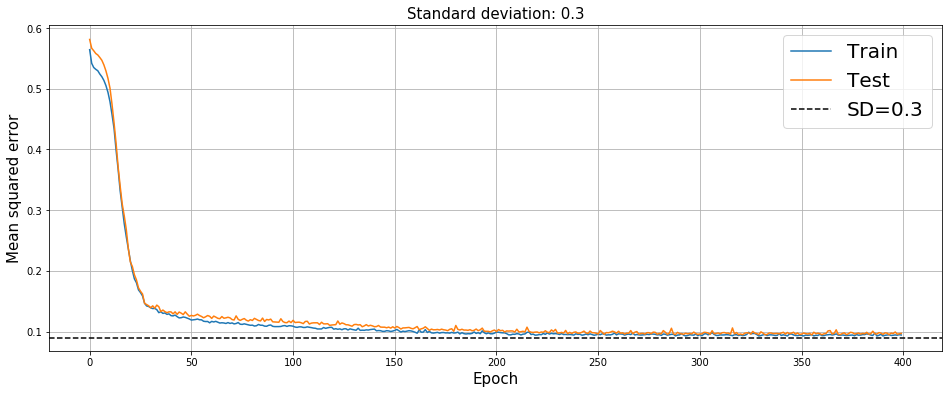

In [268]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_03)), train_loss_03, label='Train')
plt.plot(range(len(test_loss_03)), test_loss_03, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.title('Standard deviation: 0.3', fontsize=15)
plt.axhline(0.3**2, linestyle='--', color='k', label='SD=0.3')
plt.legend(fontsize=20)
plt.grid()
plt.show()

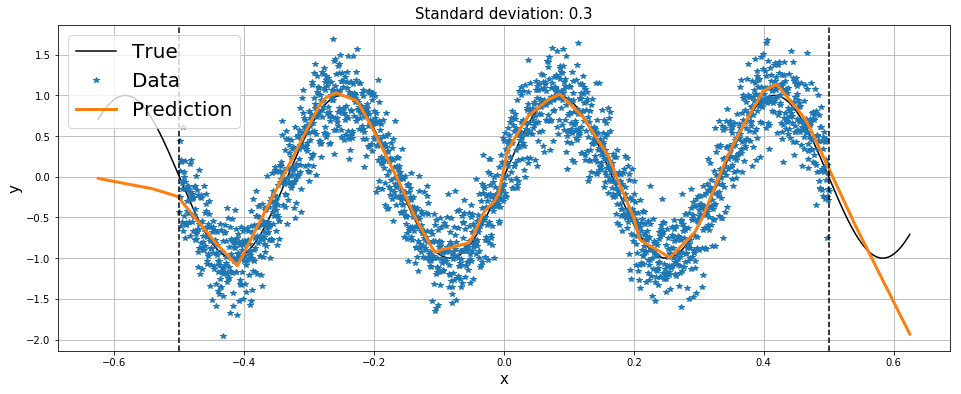

In [266]:
y_pred_model = model_03.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data_03, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Standard deviation: 0.3', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### All models

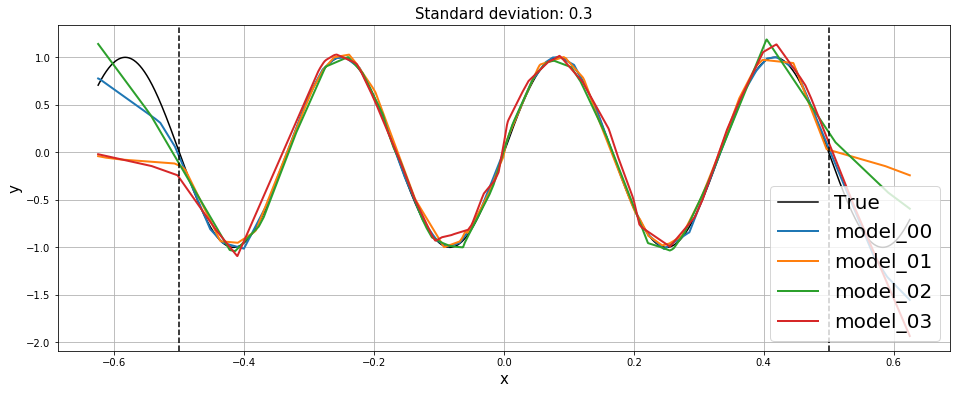

In [277]:
y_pred_model_00 = model_00.predict(X_pred)
y_pred_model_01 = model_01.predict(X_pred)
y_pred_model_02 = model_02.predict(X_pred)
y_pred_model_03 = model_03.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(X_pred, y_pred_model_00, linewidth=2, label='model_00')
plt.plot(X_pred, y_pred_model_01, linewidth=2, label='model_01')
plt.plot(X_pred, y_pred_model_02, linewidth=2, label='model_02')
plt.plot(X_pred, y_pred_model_03, linewidth=2, label='model_03')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Standard deviation: 0.3', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [294]:
loss_00 = model_00.evaluate(x=X_train_00, y=y_train_00, batch_size=batch_size, verbose=0)
loss_01 = model_01.evaluate(x=X_train_00, y=y_train_00, batch_size=batch_size, verbose=0)
loss_02 = model_02.evaluate(x=X_train_00, y=y_train_00, batch_size=batch_size, verbose=0)
loss_03 = model_03.evaluate(x=X_train_00, y=y_train_00, batch_size=batch_size, verbose=0)
loss = [loss_00, loss_01, loss_02, loss_03]

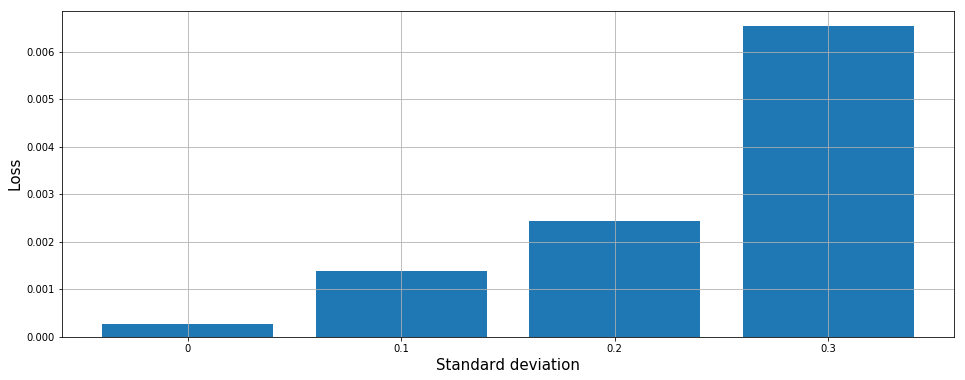

In [308]:
plt.figure(figsize=(16,6))
ind = np.arange(len(loss))
plt.bar(ind, loss)
plt.xticks(ind, ('0', '0.1', '0.2', '0.3'))
plt.xlabel('Standard deviation', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.grid()
plt.show()